In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import matplotlib.pyplot as plt

#====================  Load dataset from URL ====================
url = "https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv"
df = pd.read_csv(url)

# ====================== Separate features and target  ===============
X = df.drop("Outcome", axis=1)
y = df["Outcome"].astype(int)

# =============== Introduce some missing values randomly (10%) ===============
rng = np.random.default_rng(42)
mask = rng.random(X.shape) < 0.1
X = X.mask(mask)




In [4]:
#  ==================== Impute missing values (median) =============
X = X.fillna(X.median())


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# ==============  Balance training data with SMOTE ==============
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# ==============  Calculate scale_pos_weight ===========
neg, pos = np.bincount(y_train_bal)
scale_pos_weight = neg / pos
print(f"scale_pos_weight: {scale_pos_weight:.2f}")

# =============  Convert to DMatrix ===========
dtrain = xgb.DMatrix(X_train_bal, label=y_train_bal)
dvalid = xgb.DMatrix(X_test, label=y_test)



scale_pos_weight: 1.00


[0]	train-auc:0.89094	eval-auc:0.76617
[10]	train-auc:0.94501	eval-auc:0.81235
[20]	train-auc:0.96347	eval-auc:0.80996
[22]	train-auc:0.96593	eval-auc:0.80872
Confusion Matrix:
[[118  32]
 [ 28  53]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.79      0.80       150
           1       0.62      0.65      0.64        81

    accuracy                           0.74       231
   macro avg       0.72      0.72      0.72       231
weighted avg       0.74      0.74      0.74       231

AUC: 0.8099


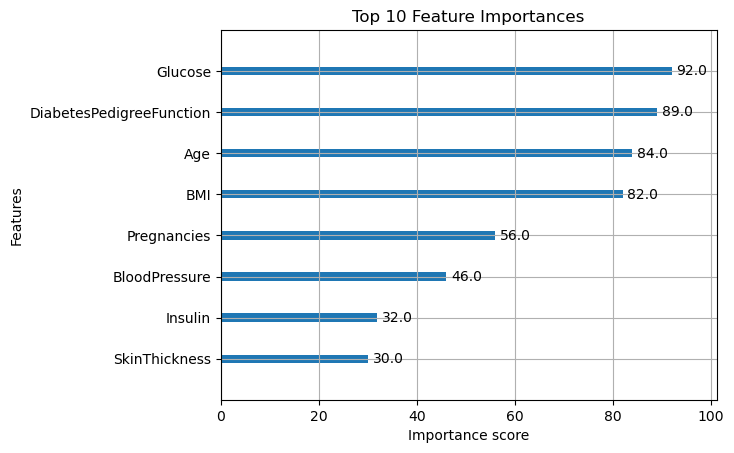

In [5]:
#  ============== XGBoost parameters =================
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'scale_pos_weight': scale_pos_weight,
    'eta': 0.1,
    'max_depth': 5,
    'seed': 42,
    'verbosity': 1
}

# ====================  Train model with early stopping =================
evals = [(dtrain, 'train'), (dvalid, 'eval')]
model = xgb.train(
    params,
    dtrain,
    num_boost_round=100,
    evals=evals,
    early_stopping_rounds=10,
    verbose_eval=10
)


y_pred_proba = model.predict(dvalid)
y_pred = (y_pred_proba >= 0.5).astype(int)


print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print(f"AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")


xgb.plot_importance(model, max_num_features=10)
plt.title("Top 10 Feature Importances")
plt.show()